## interesting, seems better using joint phi that has 

In [ ]:
import glob
import os
import torch
import numpy as np
import pandas as pd
from fig5utils import evaluate_major_diseases_wsex_with_bootstrap

# --- Fixed resources ---------------------------------------------------------
initial_psi = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt")
initial_clusters = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt")
signature_refs = torch.load(
    "/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/data_for_running/reference_trajectories.pt"
)["signature_refs"]

# master tensors; adjust paths if they live elsewhere
E_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_enrollment_full.pt")
pce_df = pd.read_csv("/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/pce_prevent_full.csv")

# helper to build model & evaluate one batch
def eval_batch(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    start = ckpt["indices"][0], 
    stop = ckpt["indices"][-1]+1  # indices saved in each checkpoint

    # slice tensors for this batch
    Y_batch = ckpt["Y"]
    E_batch = E_full[start:stop]
    cov_batch = pce_df.iloc[start:stop].reset_index(drop=True)
    if "Sex" not in cov_batch.columns and "sex" in cov_batch.columns:
        cov_batch = cov_batch.rename(columns={"sex": "Sex"})
    cov_batch = cov_batch.assign(Sex=cov_batch["Sex"], age=cov_batch["age"])  # keep original naming, but ensure present

    # append sex column to G slice (if training did)
    sex = cov_batch["Sex"].to_numpy()
    G_batch = ckpt["G"]

    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
        N=Y_batch.shape[0],
        D=Y_batch.shape[1],
        T=Y_batch.shape[2],
        K=20,
        P=G_batch.shape[1],
        init_sd_scaler=1e-1,
        G=G_batch,
        Y=Y_batch.numpy(),
        genetic_scale=1,
        W=0.0001,
        R=0,
        prevalence_t=ckpt["prevalence_t"],
        signature_references=signature_refs,
        healthy_reference=True,
        disease_names=essentials["disease_names"],
    )
    model.initialize_params(true_psi=initial_psi)
    model.clusters = ckpt["clusters"]
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    results = evaluate_major_diseases_wsex_with_bootstrap(
        model=model,
        Y_100k=Y_batch,
        E_100k=E_batch,
        disease_names=essentials["disease_names"],
        pce_df=cov_batch,
        n_bootstraps=20,
        follow_up_duration_years=10,
    )
    return (start, stop), results

# --- loop through all checkpoints --------------------------------------------
ckpt_dir = "/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs"
ckpt_paths = sorted(glob.glob(os.path.join(ckpt_dir, "enrollment_model_W0.0001_batch_*_*.pt")))

batch_results = {}
for ckpt_path in ckpt_paths:
    (start, stop), res = eval_batch(ckpt_path)
    batch_results[(start, stop)] = res
    print(f"Finished {start}-{stop}")

# Example aggregation: mean AUC per disease across batches
aggregated = {}
for batch_res in batch_results.values():
    for disease, metrics in batch_res.items():
        aggregated.setdefault(disease, []).append(metrics["auc"])

mean_auc = {disease: float(np.nanmean(vals)) for disease, vals in aggregated.items()}

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load("/Users/sarahurbut/L


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0026,  0.0050,  0.0103,  0.0132, -0.0116])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 42 diseases
Cluster 1: 24 diseases
Cluster 2: 8 diseases
Cluster 3: 5 diseases
Cluster 4: 8 diseases
Cluster 5: 13 diseases
Cluster 6: 60 diseases
Cluster 7: 30 diseases
Cluster 8: 7 diseases
Cluster 9: 19 diseases
Cluster 10: 10 diseases
Cluster 11: 15 diseases
Cluster 12: 16 diseases
Cluster 13: 11 diseases
Cluster 14: 7 diseases
Cluster 15: 7 diseases
Cluster 16: 12 diseases
Cluster 17: 16 diseases
Cluster 18: 22 diseases
Cluster 19: 16 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 42
Base value (first 5): tensor([-13.5802, -13.8155, -13.8155, -13.8155, -13.5802])
Base value centered (first 5): tensor([ 0.1123, -0.1230, -0.1230, -0.1230,  0.1123])
Base value centered mean: -4.872322278970387e-07
Gamma init for k=0 (first 5): tensor([ 3.5662e-04,  2.1659e-03, -1.1390e-05, -5.6056e-03,  4.5262e-03])

Calculating gamma for k=1:
Number of diseases in cluster: 24
Base value (first 5): tensor([-13.8155, -13.4037, -13.8155, -12.9919, -13.815

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 25 diseases
Cluster 1: 25 diseases
Cluster 2: 7 diseases
Cluster 3: 23 diseases
Cluster 4: 18 diseases
Cluster 5: 98 diseases
Cluster 6: 8 diseases
Cluster 7: 9 diseases
Cluster 8: 9 diseases
Cluster 9: 5 diseases
Cluster 10: 11 diseases
Cluster 11: 16 diseases
Cluster 12: 9 diseases
Cluster 13: 11 diseases
Cluster 14: 5 diseases
Cluster 15: 12 diseases
Cluster 16: 25 diseases
Cluster 17: 7 diseases
Cluster 18: 16 diseases
Cluster 19: 9 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 25
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.1248, -0.1248, -0.1248, -0.1248, -0.1248])
Base value centered mean: -2.417564473944367e-06
Gamma init for k=0 (first 5): tensor([ 0.0082, -0.0027,  0.0019,  0.0077,  0.0013])

Calculating gamma for k=1:
Number of diseases in cluster: 25
Base value (first 5): tensor([-13.4202, -13.4202, -13.8155, -13.8155, -13.4202])
Base value centered

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 27 diseases
Cluster 2: 9 diseases
Cluster 3: 22 diseases
Cluster 4: 13 diseases
Cluster 5: 4 diseases
Cluster 6: 13 diseases
Cluster 7: 8 diseases
Cluster 8: 15 diseases
Cluster 9: 13 diseases
Cluster 10: 27 diseases
Cluster 11: 6 diseases
Cluster 12: 12 diseases
Cluster 13: 16 diseases
Cluster 14: 9 diseases
Cluster 15: 28 diseases
Cluster 16: 8 diseases
Cluster 17: 15 diseases
Cluster 18: 87 diseases
Cluster 19: 5 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 11
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.2841, -0.2841, -0.2841, -0.2841, -0.2841])
Base value centered mean: -1.2268066029719193e-06
Gamma init for k=0 (first 5): tensor([-0.0090,  0.0233, -0.0053, -0.0131,  0.0117])

Calculating gamma for k=1:
Number of diseases in cluster: 27
Base value (first 5): tensor([-13.0834, -13.8155, -13.8155, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 6 diseases
Cluster 2: 5 diseases
Cluster 3: 18 diseases
Cluster 4: 8 diseases
Cluster 5: 6 diseases
Cluster 6: 26 diseases
Cluster 7: 97 diseases
Cluster 8: 27 diseases
Cluster 9: 12 diseases
Cluster 10: 14 diseases
Cluster 11: 15 diseases
Cluster 12: 14 diseases
Cluster 13: 6 diseases
Cluster 14: 5 diseases
Cluster 15: 18 diseases
Cluster 16: 7 diseases
Cluster 17: 9 diseases
Cluster 18: 15 diseases
Cluster 19: 29 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 11
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.2776, -0.2776, -0.2776, -0.2776, -0.2776])
Base value centered mean: -1.085281382984249e-06
Gamma init for k=0 (first 5): tensor([ 0.0013,  0.0079, -0.0060, -0.0028, -0.0029])

Calculating gamma for k=1:
Number of diseases in cluster: 6
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 13 diseases
Cluster 1: 21 diseases
Cluster 2: 16 diseases
Cluster 3: 13 diseases
Cluster 4: 13 diseases
Cluster 5: 6 diseases
Cluster 6: 9 diseases
Cluster 7: 87 diseases
Cluster 8: 8 diseases
Cluster 9: 11 diseases
Cluster 10: 12 diseases
Cluster 11: 25 diseases
Cluster 12: 11 diseases
Cluster 13: 5 diseases
Cluster 14: 8 diseases
Cluster 15: 31 diseases
Cluster 16: 18 diseases
Cluster 17: 27 diseases
Cluster 18: 7 diseases
Cluster 19: 7 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 13
Base value (first 5): tensor([-13.8155, -13.8155, -10.0141, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.2096, -0.2096,  3.5918, -0.2096, -0.2096])
Base value centered mean: -2.3460387410523253e-08
Gamma init for k=0 (first 5): tensor([-0.0077, -0.0125,  0.0149, -0.0064, -0.0079])

Calculating gamma for k=1:
Number of diseases in cluster: 21
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 18 diseases
Cluster 1: 11 diseases
Cluster 2: 20 diseases
Cluster 3: 8 diseases
Cluster 4: 8 diseases
Cluster 5: 5 diseases
Cluster 6: 26 diseases
Cluster 7: 19 diseases
Cluster 8: 5 diseases
Cluster 9: 28 diseases
Cluster 10: 11 diseases
Cluster 11: 9 diseases
Cluster 12: 16 diseases
Cluster 13: 14 diseases
Cluster 14: 14 diseases
Cluster 15: 15 diseases
Cluster 16: 8 diseases
Cluster 17: 95 diseases
Cluster 18: 11 diseases
Cluster 19: 7 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 18
Base value (first 5): tensor([-13.8155, -13.2664, -13.8155, -13.2664, -13.8155])
Base value centered (first 5): tensor([-0.5782, -0.0292, -0.5782, -0.0292, -0.5782])
Base value centered mean: 4.711151291303395e-08
Gamma init for k=0 (first 5): tensor([-0.0036, -0.0044, -0.0003,  0.0436, -0.0022])

Calculating gamma for k=1:
Number of diseases in cluster: 11
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centere

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 15 diseases
Cluster 1: 18 diseases
Cluster 2: 82 diseases
Cluster 3: 29 diseases
Cluster 4: 9 diseases
Cluster 5: 7 diseases
Cluster 6: 24 diseases
Cluster 7: 11 diseases
Cluster 8: 12 diseases
Cluster 9: 8 diseases
Cluster 10: 31 diseases
Cluster 11: 5 diseases
Cluster 12: 15 diseases
Cluster 13: 21 diseases
Cluster 14: 8 diseases
Cluster 15: 5 diseases
Cluster 16: 10 diseases
Cluster 17: 15 diseases
Cluster 18: 17 diseases
Cluster 19: 6 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 15
Base value (first 5): tensor([-13.1566, -13.1566, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 0.2335,  0.2335, -0.4255, -0.4255, -0.4255])
Base value centered mean: -4.6615599558208487e-07
Gamma init for k=0 (first 5): tensor([-0.0070, -0.0261,  0.0057,  0.0065,  0.0035])

Calculating gamma for k=1:
Number of diseases in cluster: 18
Base value (first 5): tensor([-13.8155, -13.2664, -13.8155, -11.6191, -13.2664])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 13 diseases
Cluster 2: 6 diseases
Cluster 3: 17 diseases
Cluster 4: 9 diseases
Cluster 5: 24 diseases
Cluster 6: 11 diseases
Cluster 7: 84 diseases
Cluster 8: 6 diseases
Cluster 9: 12 diseases
Cluster 10: 7 diseases
Cluster 11: 14 diseases
Cluster 12: 11 diseases
Cluster 13: 10 diseases
Cluster 14: 39 diseases
Cluster 15: 30 diseases
Cluster 16: 8 diseases
Cluster 17: 4 diseases
Cluster 18: 19 diseases
Cluster 19: 8 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 16
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.4151, -0.4151, -0.4151, -0.4151, -0.4151])
Base value centered mean: 1.1104583563792403e-06
Gamma init for k=0 (first 5): tensor([-0.0051,  0.0061, -0.0039,  0.0228, -0.0027])

Calculating gamma for k=1:
Number of diseases in cluster: 13
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value center

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 27 diseases
Cluster 2: 18 diseases
Cluster 3: 9 diseases
Cluster 4: 29 diseases
Cluster 5: 6 diseases
Cluster 6: 31 diseases
Cluster 7: 5 diseases
Cluster 8: 30 diseases
Cluster 9: 8 diseases
Cluster 10: 12 diseases
Cluster 11: 15 diseases
Cluster 12: 5 diseases
Cluster 13: 11 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 6 diseases
Cluster 17: 15 diseases
Cluster 18: 11 diseases
Cluster 19: 82 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 11
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.2780, -0.2780, -0.2780, -0.2780, -0.2780])
Base value centered mean: -5.1593779915037885e-08
Gamma init for k=0 (first 5): tensor([ 0.0073,  0.0104, -0.0130,  0.0043,  0.0043])

Calculating gamma for k=1:
Number of diseases in cluster: 27
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.4494, -13.8155])
Base value center

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 89 diseases
Cluster 1: 6 diseases
Cluster 2: 10 diseases
Cluster 3: 15 diseases
Cluster 4: 8 diseases
Cluster 5: 28 diseases
Cluster 6: 8 diseases
Cluster 7: 10 diseases
Cluster 8: 21 diseases
Cluster 9: 5 diseases
Cluster 10: 37 diseases
Cluster 11: 9 diseases
Cluster 12: 13 diseases
Cluster 13: 15 diseases
Cluster 14: 13 diseases
Cluster 15: 17 diseases
Cluster 16: 8 diseases
Cluster 17: 13 diseases
Cluster 18: 10 diseases
Cluster 19: 13 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 89
Base value (first 5): tensor([-13.7045, -13.8155, -13.8155, -13.8155, -13.3713])
Base value centered (first 5): tensor([ 0.0028, -0.1083, -0.1083, -0.1083,  0.3359])
Base value centered mean: -3.0252456326707033e-06
Gamma init for k=0 (first 5): tensor([0.0003, 0.0019, 0.0007, 0.0025, 0.0010])

Calculating gamma for k=1:
Number of diseases in cluster: 6
Base value (first 5): tensor([-13.8155, -13.8155, -12.1682, -13.8155, -13.8155])
Base value centered (

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 10 diseases
Cluster 1: 9 diseases
Cluster 2: 26 diseases
Cluster 3: 19 diseases
Cluster 4: 27 diseases
Cluster 5: 96 diseases
Cluster 6: 14 diseases
Cluster 7: 5 diseases
Cluster 8: 15 diseases
Cluster 9: 9 diseases
Cluster 10: 16 diseases
Cluster 11: 13 diseases
Cluster 12: 17 diseases
Cluster 13: 10 diseases
Cluster 14: 7 diseases
Cluster 15: 13 diseases
Cluster 16: 9 diseases
Cluster 17: 19 diseases
Cluster 18: 9 diseases
Cluster 19: 5 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 10
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.2957, -0.2957, -0.2957, -0.2957, -0.2957])
Base value centered mean: -2.559661993473128e-07
Gamma init for k=0 (first 5): tensor([-0.0019,  0.0147, -0.0188, -0.0013,  0.0114])

Calculating gamma for k=1:
Number of diseases in cluster: 9
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centere

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 28 diseases
Cluster 2: 9 diseases
Cluster 3: 24 diseases
Cluster 4: 16 diseases
Cluster 5: 9 diseases
Cluster 6: 19 diseases
Cluster 7: 16 diseases
Cluster 8: 78 diseases
Cluster 9: 12 diseases
Cluster 10: 22 diseases
Cluster 11: 18 diseases
Cluster 12: 5 diseases
Cluster 13: 5 diseases
Cluster 14: 13 diseases
Cluster 15: 22 diseases
Cluster 16: 11 diseases
Cluster 17: 8 diseases
Cluster 18: 15 diseases
Cluster 19: 7 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 11
Base value (first 5): tensor([-13.8155, -13.8155, -12.9170, -13.8155, -10.2214])
Base value centered (first 5): tensor([-0.2756, -0.2756,  0.6229, -0.2756,  3.3185])
Base value centered mean: 1.062583919519966e-06
Gamma init for k=0 (first 5): tensor([-0.0001,  0.0099,  0.0081,  0.0057,  0.0021])

Calculating gamma for k=1:
Number of diseases in cluster: 28
Base value (first 5): tensor([-13.8155, -13.8155, -12.7565, -13.8155, -13.4625])
Base value center

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 12 diseases
Cluster 1: 29 diseases
Cluster 2: 11 diseases
Cluster 3: 12 diseases
Cluster 4: 16 diseases
Cluster 5: 7 diseases
Cluster 6: 10 diseases
Cluster 7: 6 diseases
Cluster 8: 96 diseases
Cluster 9: 14 diseases
Cluster 10: 8 diseases
Cluster 11: 7 diseases
Cluster 12: 16 diseases
Cluster 13: 36 diseases
Cluster 14: 6 diseases
Cluster 15: 8 diseases
Cluster 16: 11 diseases
Cluster 17: 27 diseases
Cluster 18: 11 diseases
Cluster 19: 5 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 12
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.4783, -0.4783, -0.4783, -0.4783, -0.4783])
Base value centered mean: -1.1146545375595451e-06
Gamma init for k=0 (first 5): tensor([-0.0025, -0.0013, -0.0089,  0.0018, -0.0128])

Calculating gamma for k=1:
Number of diseases in cluster: 29
Base value (first 5): tensor([-12.7931, -13.8155, -13.8155, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 7 diseases
Cluster 2: 14 diseases
Cluster 3: 102 diseases
Cluster 4: 9 diseases
Cluster 5: 18 diseases
Cluster 6: 5 diseases
Cluster 7: 26 diseases
Cluster 8: 9 diseases
Cluster 9: 8 diseases
Cluster 10: 12 diseases
Cluster 11: 14 diseases
Cluster 12: 14 diseases
Cluster 13: 10 diseases
Cluster 14: 5 diseases
Cluster 15: 12 diseases
Cluster 16: 25 diseases
Cluster 17: 5 diseases
Cluster 18: 24 diseases
Cluster 19: 13 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 16
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.4371, -0.4371, -0.4371, -0.4371, -0.4371])
Base value centered mean: -6.149292062218592e-07
Gamma init for k=0 (first 5): tensor([-0.0152,  0.0037, -0.0070,  0.0305, -0.0032])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -10.9916])
Base value center

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 10 diseases
Cluster 2: 16 diseases
Cluster 3: 27 diseases
Cluster 4: 35 diseases
Cluster 5: 9 diseases
Cluster 6: 9 diseases
Cluster 7: 8 diseases
Cluster 8: 5 diseases
Cluster 9: 81 diseases
Cluster 10: 11 diseases
Cluster 11: 12 diseases
Cluster 12: 16 diseases
Cluster 13: 15 diseases
Cluster 14: 8 diseases
Cluster 15: 5 diseases
Cluster 16: 24 diseases
Cluster 17: 10 diseases
Cluster 18: 15 diseases
Cluster 19: 16 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 16
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.1978])
Base value centered (first 5): tensor([-0.4276, -0.4276, -0.4276, -0.4276,  0.1901])
Base value centered mean: 2.0751953400122147e-07
Gamma init for k=0 (first 5): tensor([ 0.0121,  0.0034,  0.0011,  0.0074, -0.0037])

Calculating gamma for k=1:
Number of diseases in cluster: 10
Base value (first 5): tensor([-13.8155, -12.8271, -13.8155, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 17 diseases
Cluster 1: 14 diseases
Cluster 2: 5 diseases
Cluster 3: 37 diseases
Cluster 4: 20 diseases
Cluster 5: 10 diseases
Cluster 6: 86 diseases
Cluster 7: 24 diseases
Cluster 8: 6 diseases
Cluster 9: 13 diseases
Cluster 10: 8 diseases
Cluster 11: 17 diseases
Cluster 12: 5 diseases
Cluster 13: 11 diseases
Cluster 14: 8 diseases
Cluster 15: 10 diseases
Cluster 16: 4 diseases
Cluster 17: 8 diseases
Cluster 18: 10 diseases
Cluster 19: 35 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 17
Base value (first 5): tensor([-13.2341, -13.2341, -13.2341, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 0.1752,  0.1752,  0.1752, -0.4062, -0.4062])
Base value centered mean: -1.8898010694101686e-06
Gamma init for k=0 (first 5): tensor([-0.0154,  0.0114, -0.0027,  0.0071,  0.0143])

Calculating gamma for k=1:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 28 diseases
Cluster 1: 29 diseases
Cluster 2: 14 diseases
Cluster 3: 8 diseases
Cluster 4: 102 diseases
Cluster 5: 13 diseases
Cluster 6: 9 diseases
Cluster 7: 16 diseases
Cluster 8: 19 diseases
Cluster 9: 7 diseases
Cluster 10: 16 diseases
Cluster 11: 13 diseases
Cluster 12: 6 diseases
Cluster 13: 6 diseases
Cluster 14: 5 diseases
Cluster 15: 13 diseases
Cluster 16: 15 diseases
Cluster 17: 6 diseases
Cluster 18: 12 diseases
Cluster 19: 11 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 28
Base value (first 5): tensor([-13.8155, -13.4625, -13.4625, -13.4625, -13.8155])
Base value centered (first 5): tensor([-0.3240,  0.0290,  0.0290,  0.0290, -0.3240])
Base value centered mean: 3.8537979207831086e-07
Gamma init for k=0 (first 5): tensor([-0.0098, -0.0006, -0.0072,  0.0278,  0.0084])

Calculating gamma for k=1:
Number of diseases in cluster: 29
Base value (first 5): tensor([-11.7706, -13.1339, -13.4747, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 88 diseases
Cluster 1: 17 diseases
Cluster 2: 13 diseases
Cluster 3: 17 diseases
Cluster 4: 17 diseases
Cluster 5: 9 diseases
Cluster 6: 10 diseases
Cluster 7: 21 diseases
Cluster 8: 23 diseases
Cluster 9: 4 diseases
Cluster 10: 8 diseases
Cluster 11: 9 diseases
Cluster 12: 4 diseases
Cluster 13: 22 diseases
Cluster 14: 21 diseases
Cluster 15: 11 diseases
Cluster 16: 26 diseases
Cluster 17: 6 diseases
Cluster 18: 8 diseases
Cluster 19: 14 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 88
Base value (first 5): tensor([-13.7032, -13.8155, -13.8155, -13.8155, -13.5909])
Base value centered (first 5): tensor([-0.0109, -0.1232, -0.1232, -0.1232,  0.1014])
Base value centered mean: 1.0121345894731348e-06
Gamma init for k=0 (first 5): tensor([-0.0040, -0.0031, -0.0013,  0.0068,  0.0021])

Calculating gamma for k=1:
Number of diseases in cluster: 17
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value center

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 28 diseases
Cluster 1: 16 diseases
Cluster 2: 17 diseases
Cluster 3: 14 diseases
Cluster 4: 6 diseases
Cluster 5: 23 diseases
Cluster 6: 28 diseases
Cluster 7: 8 diseases
Cluster 8: 10 diseases
Cluster 9: 9 diseases
Cluster 10: 10 diseases
Cluster 11: 65 diseases
Cluster 12: 14 diseases
Cluster 13: 13 diseases
Cluster 14: 2 diseases
Cluster 15: 6 diseases
Cluster 16: 20 diseases
Cluster 17: 5 diseases
Cluster 18: 47 diseases
Cluster 19: 7 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 28
Base value (first 5): tensor([-13.8155, -13.8155, -13.4625, -12.4036, -13.4625])
Base value centered (first 5): tensor([-0.1091, -0.1091,  0.2439,  1.3028,  0.2439])
Base value centered mean: -2.0107270302105462e-06
Gamma init for k=0 (first 5): tensor([ 0.0049,  0.0018,  0.0008, -0.0018, -0.0021])

Calculating gamma for k=1:
Number of diseases in cluster: 16
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 15 diseases
Cluster 1: 95 diseases
Cluster 2: 6 diseases
Cluster 3: 25 diseases
Cluster 4: 8 diseases
Cluster 5: 14 diseases
Cluster 6: 7 diseases
Cluster 7: 22 diseases
Cluster 8: 24 diseases
Cluster 9: 8 diseases
Cluster 10: 13 diseases
Cluster 11: 12 diseases
Cluster 12: 9 diseases
Cluster 13: 15 diseases
Cluster 14: 13 diseases
Cluster 15: 18 diseases
Cluster 16: 20 diseases
Cluster 17: 5 diseases
Cluster 18: 9 diseases
Cluster 19: 10 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 15
Base value (first 5): tensor([-11.1799, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 2.1783, -0.4574, -0.4574, -0.4574, -0.4574])
Base value centered mean: 8.01086397217432e-09
Gamma init for k=0 (first 5): tensor([-0.0181,  0.0058, -0.0161,  0.0112,  0.0028])

Calculating gamma for k=1:
Number of diseases in cluster: 95
Base value (first 5): tensor([-13.0872, -13.8155, -13.8155, -13.7115, -13.8155])
Base value centered

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 13 diseases
Cluster 1: 15 diseases
Cluster 2: 11 diseases
Cluster 3: 102 diseases
Cluster 4: 17 diseases
Cluster 5: 26 diseases
Cluster 6: 9 diseases
Cluster 7: 14 diseases
Cluster 8: 7 diseases
Cluster 9: 10 diseases
Cluster 10: 28 diseases
Cluster 11: 5 diseases
Cluster 12: 16 diseases
Cluster 13: 24 diseases
Cluster 14: 8 diseases
Cluster 15: 5 diseases
Cluster 16: 10 diseases
Cluster 17: 12 diseases
Cluster 18: 9 diseases
Cluster 19: 7 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 13
Base value (first 5): tensor([-13.8155, -13.8155, -13.0552, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.4816, -0.4816,  0.2786, -0.4816, -0.4816])
Base value centered mean: -6.187439112181892e-07
Gamma init for k=0 (first 5): tensor([-0.0099,  0.0068, -0.0064,  0.0204, -0.0054])

Calculating gamma for k=1:
Number of diseases in cluster: 15
Base value (first 5): tensor([-13.8155, -13.1566, -13.8155, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 11 diseases
Cluster 2: 7 diseases
Cluster 3: 13 diseases
Cluster 4: 16 diseases
Cluster 5: 8 diseases
Cluster 6: 5 diseases
Cluster 7: 31 diseases
Cluster 8: 28 diseases
Cluster 9: 9 diseases
Cluster 10: 13 diseases
Cluster 11: 9 diseases
Cluster 12: 8 diseases
Cluster 13: 5 diseases
Cluster 14: 18 diseases
Cluster 15: 80 diseases
Cluster 16: 16 diseases
Cluster 17: 9 diseases
Cluster 18: 14 diseases
Cluster 19: 32 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 16
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.1978, -13.8155])
Base value centered (first 5): tensor([-0.1809, -0.1809, -0.1809,  0.4368, -0.1809])
Base value centered mean: -1.900291408674093e-06
Gamma init for k=0 (first 5): tensor([ 0.0059,  0.0030, -0.0071,  0.0108,  0.0209])

Calculating gamma for k=1:
Number of diseases in cluster: 11
Base value (first 5): tensor([-13.8155, -13.8155, -11.1200, -13.8155, -13.8155])
Base value centere

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 27 diseases
Cluster 2: 12 diseases
Cluster 3: 11 diseases
Cluster 4: 27 diseases
Cluster 5: 8 diseases
Cluster 6: 4 diseases
Cluster 7: 13 diseases
Cluster 8: 8 diseases
Cluster 9: 8 diseases
Cluster 10: 7 diseases
Cluster 11: 7 diseases
Cluster 12: 32 diseases
Cluster 13: 12 diseases
Cluster 14: 20 diseases
Cluster 15: 22 diseases
Cluster 16: 10 diseases
Cluster 17: 15 diseases
Cluster 18: 85 diseases
Cluster 19: 6 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -12.4036, -13.1095, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.4406,  0.9714,  0.2654, -0.4406, -0.4406])
Base value centered mean: -1.1138916278241595e-07
Gamma init for k=0 (first 5): tensor([-0.0159,  0.0060, -0.0029,  0.0295, -0.0005])

Calculating gamma for k=1:
Number of diseases in cluster: 27
Base value (first 5): tensor([-13.8155, -13.0834, -13.8155, -13.8155, -13.8155])
Base value cente

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 28 diseases
Cluster 1: 11 diseases
Cluster 2: 13 diseases
Cluster 3: 11 diseases
Cluster 4: 18 diseases
Cluster 5: 6 diseases
Cluster 6: 9 diseases
Cluster 7: 8 diseases
Cluster 8: 16 diseases
Cluster 9: 9 diseases
Cluster 10: 6 diseases
Cluster 11: 26 diseases
Cluster 12: 14 diseases
Cluster 13: 18 diseases
Cluster 14: 22 diseases
Cluster 15: 12 diseases
Cluster 16: 31 diseases
Cluster 17: 4 diseases
Cluster 18: 17 diseases
Cluster 19: 69 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 28
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.1363, -0.1363, -0.1363, -0.1363, -0.1363])
Base value centered mean: 1.3012886483920738e-06
Gamma init for k=0 (first 5): tensor([0.0094, 0.0038, 0.0029, 0.0004, 0.0003])

Calculating gamma for k=1:
Number of diseases in cluster: 11
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -12.0185])
Base value centered (

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 26 diseases
Cluster 1: 24 diseases
Cluster 2: 21 diseases
Cluster 3: 7 diseases
Cluster 4: 8 diseases
Cluster 5: 5 diseases
Cluster 6: 86 diseases
Cluster 7: 9 diseases
Cluster 8: 8 diseases
Cluster 9: 7 diseases
Cluster 10: 25 diseases
Cluster 11: 21 diseases
Cluster 12: 13 diseases
Cluster 13: 10 diseases
Cluster 14: 5 diseases
Cluster 15: 13 diseases
Cluster 16: 11 diseases
Cluster 17: 8 diseases
Cluster 18: 29 diseases
Cluster 19: 12 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 26
Base value (first 5): tensor([-13.8155, -13.4354, -13.0552, -13.8155, -12.6751])
Base value centered (first 5): tensor([-0.5370, -0.1569,  0.2233, -0.5370,  0.6034])
Base value centered mean: -1.7039299109455897e-06
Gamma init for k=0 (first 5): tensor([-0.0111, -0.0022,  0.0007,  0.0279,  0.0090])

Calculating gamma for k=1:
Number of diseases in cluster: 24
Base value (first 5): tensor([-13.4037, -13.8155, -13.8155, -13.4037, -12.5800])
Base value center

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 12 diseases
Cluster 1: 15 diseases
Cluster 2: 16 diseases
Cluster 3: 52 diseases
Cluster 4: 5 diseases
Cluster 5: 15 diseases
Cluster 6: 13 diseases
Cluster 7: 12 diseases
Cluster 8: 76 diseases
Cluster 9: 5 diseases
Cluster 10: 9 diseases
Cluster 11: 5 diseases
Cluster 12: 7 diseases
Cluster 13: 25 diseases
Cluster 14: 6 diseases
Cluster 15: 11 diseases
Cluster 16: 7 diseases
Cluster 17: 13 diseases
Cluster 18: 12 diseases
Cluster 19: 32 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 12
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.2619, -0.2619, -0.2619, -0.2619, -0.2619])
Base value centered mean: -6.68334962483641e-07
Gamma init for k=0 (first 5): tensor([ 3.2110e-03,  2.1911e-02, -1.4193e-02,  3.4729e-03,  7.1710e-05])

Calculating gamma for k=1:
Number of diseases in cluster: 15
Base value (first 5): tensor([-13.8155, -13.1566, -13.8155, -13.8155, -13.8155]

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 22 diseases
Cluster 1: 24 diseases
Cluster 2: 16 diseases
Cluster 3: 5 diseases
Cluster 4: 8 diseases
Cluster 5: 9 diseases
Cluster 6: 31 diseases
Cluster 7: 16 diseases
Cluster 8: 9 diseases
Cluster 9: 8 diseases
Cluster 10: 13 diseases
Cluster 11: 17 diseases
Cluster 12: 14 diseases
Cluster 13: 8 diseases
Cluster 14: 5 diseases
Cluster 15: 12 diseases
Cluster 16: 12 diseases
Cluster 17: 88 diseases
Cluster 18: 9 diseases
Cluster 19: 22 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 22
Base value (first 5): tensor([-13.3663, -13.3663, -12.9170, -13.8155, -13.3663])
Base value centered (first 5): tensor([ 0.0837,  0.0837,  0.5329, -0.3656,  0.0837])
Base value centered mean: 4.0941239376479643e-07
Gamma init for k=0 (first 5): tensor([-0.0009,  0.0022, -0.0023,  0.0160, -0.0027])

Calculating gamma for k=1:
Number of diseases in cluster: 24
Base value (first 5): tensor([-13.8155, -12.9919, -13.8155, -13.8155, -13.4037])
Base value centere

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 13 diseases
Cluster 1: 14 diseases
Cluster 2: 28 diseases
Cluster 3: 80 diseases
Cluster 4: 9 diseases
Cluster 5: 14 diseases
Cluster 6: 13 diseases
Cluster 7: 12 diseases
Cluster 8: 17 diseases
Cluster 9: 14 diseases
Cluster 10: 7 diseases
Cluster 11: 22 diseases
Cluster 12: 9 diseases
Cluster 13: 5 diseases
Cluster 14: 35 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 7 diseases
Cluster 18: 7 diseases
Cluster 19: 8 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 13
Base value (first 5): tensor([ -7.7332, -13.8155, -11.5347, -13.8155, -12.2949])
Base value centered (first 5): tensor([ 5.5695, -0.5128,  1.7680, -0.5128,  1.0078])
Base value centered mean: -8.111953775369329e-07
Gamma init for k=0 (first 5): tensor([ 0.0005,  0.0003, -0.0077,  0.0140, -0.0024])

Calculating gamma for k=1:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.1095, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centere

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 14 diseases
Cluster 2: 17 diseases
Cluster 3: 8 diseases
Cluster 4: 16 diseases
Cluster 5: 114 diseases
Cluster 6: 13 diseases
Cluster 7: 10 diseases
Cluster 8: 16 diseases
Cluster 9: 9 diseases
Cluster 10: 6 diseases
Cluster 11: 10 diseases
Cluster 12: 9 diseases
Cluster 13: 11 diseases
Cluster 14: 5 diseases
Cluster 15: 9 diseases
Cluster 16: 16 diseases
Cluster 17: 24 diseases
Cluster 18: 12 diseases
Cluster 19: 18 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 11
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -12.9170, -13.8155])
Base value centered (first 5): tensor([-0.2696, -0.2696, -0.2696,  0.6290, -0.2696])
Base value centered mean: -3.633499261468387e-07
Gamma init for k=0 (first 5): tensor([ 0.0007,  0.0176, -0.0034, -0.0108,  0.0098])

Calculating gamma for k=1:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.1095, -13.1095, -13.8155, -13.8155])
Base value cent

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 17 diseases
Cluster 1: 24 diseases
Cluster 2: 5 diseases
Cluster 3: 10 diseases
Cluster 4: 16 diseases
Cluster 5: 13 diseases
Cluster 6: 12 diseases
Cluster 7: 20 diseases
Cluster 8: 32 diseases
Cluster 9: 9 diseases
Cluster 10: 100 diseases
Cluster 11: 13 diseases
Cluster 12: 9 diseases
Cluster 13: 8 diseases
Cluster 14: 17 diseases
Cluster 15: 5 diseases
Cluster 16: 4 diseases
Cluster 17: 14 diseases
Cluster 18: 11 diseases
Cluster 19: 9 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 17
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -12.0713])
Base value centered (first 5): tensor([-0.4337, -0.4337, -0.4337, -0.4337,  1.3105])
Base value centered mean: -1.1537551927176537e-06
Gamma init for k=0 (first 5): tensor([-0.0155,  0.0075,  0.0029,  0.0040,  0.0089])

Calculating gamma for k=1:
Number of diseases in cluster: 24
Base value (first 5): tensor([-12.9919, -11.7564, -13.8155, -13.8155, -13.8155])
Base value cent

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64645/3866029564.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c


Cluster Sizes:
Cluster 0: 7 diseases
Cluster 1: 20 diseases
Cluster 2: 8 diseases
Cluster 3: 19 diseases
Cluster 4: 7 diseases
Cluster 5: 22 diseases
Cluster 6: 12 diseases
Cluster 7: 15 diseases
Cluster 8: 9 diseases
Cluster 9: 5 diseases
Cluster 10: 9 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 15 diseases
Cluster 14: 5 diseases
Cluster 15: 13 diseases
Cluster 16: 8 diseases
Cluster 17: 22 diseases
Cluster 18: 20 diseases
Cluster 19: 94 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.1941, -0.1941, -0.1941, -0.1941, -0.1941])
Base value centered mean: -6.667137313343119e-07
Gamma init for k=0 (first 5): tensor([-0.0112,  0.0039,  0.0012,  0.0122,  0.0092])

Calculating gamma for k=1:
Number of diseases in cluster: 20
Base value (first 5): tensor([-13.8155, -13.3213, -13.3213, -13.8155, -13.8155])
Base value centered

In [106]:
import pandas as pd

def summarize_batch(batch_dict):
    rows = []
    for disease, metrics in batch_dict.items():
        rows.append({
            "Disease": disease,
            "AUC": metrics["auc"],
            "n_events": metrics["n_events"],
            "Event_Rate_%": metrics["event_rate"],
            "CI_lower": metrics["ci_lower"],
            "CI_upper": metrics["ci_upper"],
        })
    df = pd.DataFrame(rows)
    df = df.sort_values("AUC", ascending=False)
    df = df[["Disease", "AUC", "n_events", "Event_Rate_%", "CI_lower", "CI_upper"]]
    return df

batch_key = (0,9999)
summary_df = summarize_batch(batch_results[batch_key])
summary_df.round({"AUC": 3, "Event_Rate_%": 3, "CI_lower": 3, "CI_upper": 3})

,Disease,AUC,n_events,Event_Rate_%,CI_lower,CI_upper
25,Parkinsons,0.741,46,0.460,0.674,0.791
15,Bladder_Cancer,0.740,49,0.490,0.671,0.792
0,ASCVD,0.712,831,8.311,0.701,0.725
3,CKD,0.708,207,2.070,0.678,0.729
6,Heart_Failure,0.698,205,2.050,0.665,0.731
14,Lung_Cancer,0.691,75,0.750,0.620,0.733
2,Atrial_Fib,0.684,376,3.760,0.666,0.700
7,Pneumonia,0.683,335,3.350,0.660,0.703
4,All_Cancers,0.680,480,4.800,0.657,0.702
9,Osteoporosis,0.676,219,2.190,0.645,0.711


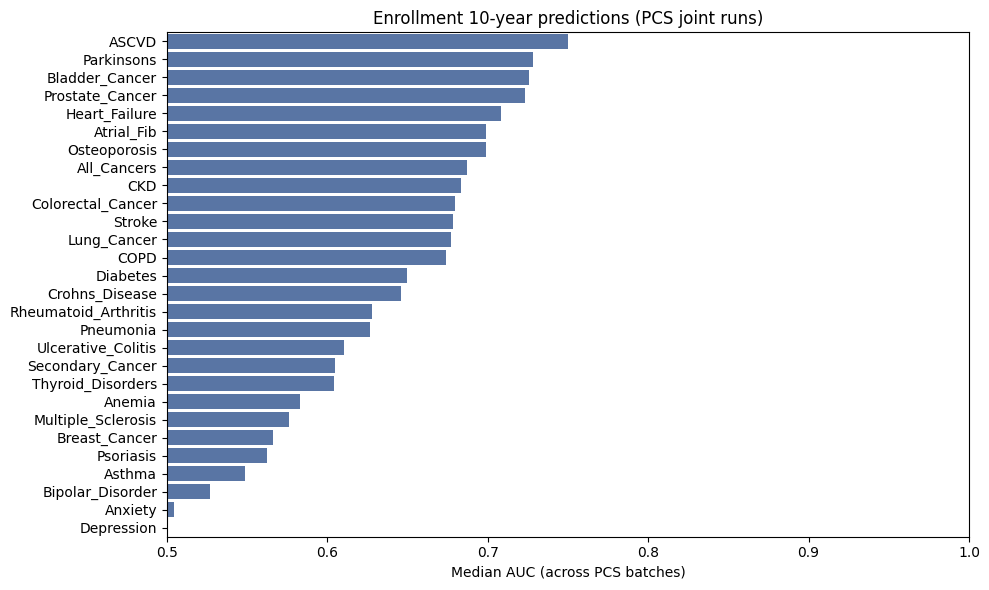

In [109]:
# Collect per-disease AUC lists
disease_aucs = {}
for batch_res in batch_results.values():
    for disease, metrics in batch_res.items():
        disease_aucs.setdefault(disease, []).append(metrics["auc"])

# Median AUC and optional IQR
median_auc_df = (
    pd.Series({d: np.nanmedian(vals) for d, vals in disease_aucs.items()}, name="MedianAUC")
      .reset_index()
      .rename(columns={"index": "Disease"})
      .sort_values("MedianAUC", ascending=False)
)
median_auc_df["IQR"] = [
    (np.nanpercentile(disease_aucs[d], 25), np.nanpercentile(disease_aucs[d], 75))
    for d in median_auc_df["Disease"]
]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=median_auc_df,
    x="MedianAUC",
    y="Disease",
    color="#4c72b0"
)
plt.xlim(0.5, 1.0)
plt.xlabel("Median AUC (across PCS batches)")
plt.ylabel("")
plt.title("Enrollment 10-year predictions (PCS joint runs)")
plt.tight_layout()
plt.show()

In [110]:
median_auc_df

,Disease,MedianAUC,IQR
0,ASCVD,0.750280,"(0.7438776688071792, 0.7594445597781294)"
25,Parkinsons,0.728468,"(0.687040955637512, 0.7594882443476272)"
15,Bladder_Cancer,0.725478,"(0.6990358127948645, 0.7718035585555441)"
13,Prostate_Cancer,0.723011,"(0.7106038898905311, 0.7407479989886474)"
6,Heart_Failure,0.708380,"(0.6787676793761548, 0.7386886683560091)"
2,Atrial_Fib,0.699009,"(0.6873615854951403, 0.7073028355491868)"
9,Osteoporosis,0.698976,"(0.6838934790841621, 0.7084674170333813)"
4,All_Cancers,0.686938,"(0.677136787982987, 0.6992615961709173)"
3,CKD,0.683149,"(0.6590367292390903, 0.7033055088499729)"
11,Colorectal_Cancer,0.679574,"(0.6499496767189368, 0.7032568467920572)"


# now with fixed phi

In [ ]:
    # --- loop through all checkpoints --------------------------------------------
ckpt_dir = "/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs"
ckpt_paths = sorted(glob.glob(os.path.join(ckpt_dir, "enrollment_model_W0.0001_batch_*_*.pt")))

ckpt = torch.load(ckpt_path, map_location="cpu")
ckpt = torch.load(ckpt_paths[0], map_location="cpu")
G_batch_dummy=ckpt["G"]
G_batch_dummy.shape



torch.Size([10000, 47])

In [ ]:
import glob
import os
import torch
import numpy as np
import pandas as pd
from fig5utils import evaluate_major_diseases_wsex_with_bootstrap

# --- Fixed resources ---------------------------------------------------------
initial_psi = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt")
initial_clusters = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt")
signature_refs = torch.load(
    "/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/data_for_running/reference_trajectories.pt"
)["signature_refs"]


# master tensors; adjust paths if they live elsewhere
Y_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt")
E_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_matrix.pt")
G_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/G_matrix.pt")

# helper to build model & evaluate one batch

# helper to build model & evaluate one batch
def eval_batch(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    start, stop = ckpt["start_index"], ckpt["end_index"]  # indices saved in each checkpoint

  
    Y_batch = Y_full[start:stop]
    E_batch = E_full[start:stop]
# master tensors; adjust paths if 
    cov_batch = pce_df.iloc[start:stop].reset_index(drop=True)
    if "Sex" not in cov_batch.columns and "sex" in cov_batch.columns:
        cov_batch = cov_batch.rename(columns={"sex": "Sex"})
    cov_batch = cov_batch.assign(Sex=cov_batch["Sex"], age=cov_batch["age"])  # keep original naming, but ensure present

  

    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
        N=Y_batch.shape[0],
        D=Y_batch.shape[1],
        T=Y_batch.shape[2],
        K=20,
        P=G_batch_dummy.shape[1],
        init_sd_scaler=1e-1,
        G=G_batch_dummy,
        Y=Y_batch.numpy(),
        genetic_scale=1,
        W=0.0001,
        R=0,
        prevalence_t=ckpt["prevalence_t"],
        signature_references=signature_refs,
        healthy_reference=True,
        disease_names=essentials["disease_names"],
    )
    model.initialize_params(true_psi=initial_psi)
    model.clusters = clusters
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    results = evaluate_major_diseases_wsex_with_bootstrap(
        model=model,
        Y_100k=Y_batch,
        E_100k=E_batch,
        disease_names=essentials["disease_names"],
        pce_df=cov_batch,
        n_bootstraps=20,
        follow_up_duration_years=10,
    )
    return (start, stop), results

# --- loop through all checkpoints --------------------------------------------
ckpt_dir = "/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/"
ckpt_paths = sorted(glob.glob(os.path.join(ckpt_dir, "model_enroll_fixedphi_sex_*_*pt")))

batch_results_fixed = {}
for ckpt_path in ckpt_paths:
    (start, stop), res = eval_batch(ckpt_path)
    batch_results_fixed[(start, stop)] = res
    print(f"Finished {start}-{stop}")



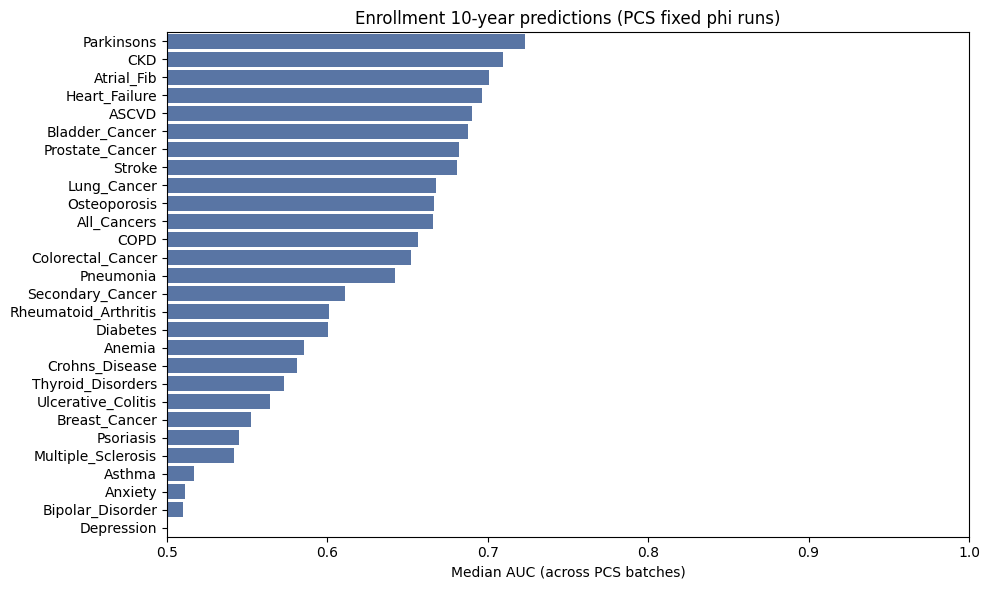

In [89]:
# Collect per-disease AUC lists
# Collect per-disease AUC lists
disease_aucs = {}
for batch_res in batch_results_fixed.values():
    for disease, metrics in batch_res.items():
        disease_aucs.setdefault(disease, []).append(metrics["auc"])
# Median AUC and optional IQR
median_auc_df = (
    pd.Series({d: np.nanmedian(vals) for d, vals in disease_aucs.items()}, name="MedianAUC")
      .reset_index()
      .rename(columns={"index": "Disease"})
      .sort_values("MedianAUC", ascending=False)
)
median_auc_df["IQR"] = [
    (np.nanpercentile(disease_aucs[d], 25), np.nanpercentile(disease_aucs[d], 75))
    for d in median_auc_df["Disease"]
]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=median_auc_df,
    x="MedianAUC",
    y="Disease",
    color="#4c72b0"
)
plt.xlim(0.5, 1.0)
plt.xlabel("Median AUC (across PCS batches)")
plt.ylabel("")
plt.title("Enrollment 10-year predictions (PCS fixed phi runs)")
plt.tight_layout()
plt.show()



In [90]:
median_auc_df

,Disease,MedianAUC,IQR
25,Parkinsons,0.723287,"(0.7006739947088888, 0.7350448448759156)"
3,CKD,0.709569,"(0.6959795023997335, 0.7212934347630464)"
2,Atrial_Fib,0.700961,"(0.6956021036173877, 0.7065246422324016)"
6,Heart_Failure,0.696508,"(0.6840285749505227, 0.7092856489776234)"
0,ASCVD,0.690504,"(0.687024851605815, 0.6957537595846406)"
15,Bladder_Cancer,0.687863,"(0.6711628375144197, 0.7177438595346327)"
13,Prostate_Cancer,0.682186,"(0.6732213516718387, 0.6927466837098463)"
5,Stroke,0.680831,"(0.6670988047959159, 0.6900001945801346)"
14,Lung_Cancer,0.668059,"(0.6480351895703084, 0.6896500862509662)"
9,Osteoporosis,0.666339,"(0.660529718216929, 0.6761245680602511)"
